In [42]:
# -------------------------------
# 3D Ultrasonic Pipe Visualization (Notebook-ready)
# -------------------------------

import os
import json
import numpy as np
import pandas as pd
import pyvista as pv

# -------------------------------
# 1. Paths
# -------------------------------
data_folder = "/home/narges/Downloads/Simulated ultrasonic pulse-echo well-integrity dataset/Json Files"
metadata_file = "/home/narges/Downloads/Simulated ultrasonic pulse-echo well-integrity dataset/Metadata_overview.csv"

# -------------------------------
# 2. Load metadata
# -------------------------------
meta = pd.read_csv(metadata_file)
print("Metadata loaded. First 5 rows:")
print(meta.head())

# -------------------------------
# 3. Select JSON files
# -------------------------------
files = sorted([f for f in os.listdir(data_folder) if f.endswith(".json")])[:200]  # use first 200 files for performance

# Map one angle per file around pipe
angles = np.linspace(0, 2 * np.pi, len(files), endpoint=False)

# -------------------------------
# 4. Prepare 3D points
# -------------------------------
volume_points = []

# Example: constant inner radius (from metadata, diameter / 2)
r_inner = 0.0125  # 25 mm pipe → radius 0.0125 m

for i, fname in enumerate(files):
    file_id = int(fname.replace(".json", ""))
    
    # Get metadata row
    row = meta[meta['file_ID'] == file_id]
    if row.empty:
        continue
    
    # Load JSON waveform
    with open(os.path.join(data_folder, fname), "r") as f:
        trace = json.load(f)
    
    wf = trace["waveform"]
    amplitude = np.array(wf["values"])
    
    # Normalize amplitude (0 to 1)
    amplitude = (amplitude - amplitude.min()) / (amplitude.max() - amplitude.min())
    
    # Map slice around pipe circumference
    theta = angles[i]
    z = np.linspace(0, 1, len(amplitude))  # axial direction
    r = r_inner * np.ones_like(z)
    
    # Convert polar to Cartesian
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    
    # Add points with amplitude as scalar
    for zi, xi, yi, ai in zip(z, x, y, amplitude):
        volume_points.append([xi, yi, zi, ai])

# Convert to NumPy arrays
volume_points = np.array(volume_points)
xyz = volume_points[:, :3]
intensity = volume_points[:, 3]

print("Total points loaded:", xyz.shape[0])

# -------------------------------
# 5. 3D Visualization in Notebook
# -------------------------------
# Use valid PyVista Jupyter backend
pv.set_jupyter_backend("client")  # interactive in notebook

# Create PyVista point cloud
cloud = pv.PolyData(xyz)
cloud['amplitude'] = intensity

# Plot
pl = pv.Plotter(notebook=True)
pl.add_points(
    cloud, scalars='amplitude', render_points_as_spheres=True,
    point_size=5, cmap='viridis'
)
pl.show()


Metadata loaded. First 5 rows:
   file_ID  domain      interface geometry    symmetries  focal_length  \
0        1     2.5  time explicit    plate  axisymmetric           0.2   
1        2     2.5  time explicit    plate  axisymmetric           0.2   
2        3     2.5  time explicit    plate  axisymmetric           0.2   
3        4     2.5  time explicit    plate  axisymmetric           0.2   
4        5     2.5  time explicit    plate  axisymmetric           0.2   

   diameter   bw      f0    material_in  ...  rho_out  vp_out  vs_out  \
0     0.025  0.7  250000  oil based mud  ...     1980    3350    1920   
1     0.025  0.7  250000  oil based mud  ...     1980    3350    1920   
2     0.025  0.7  250000  oil based mud  ...     1980    3350    1920   
3     0.025  0.7  250000  oil based mud  ...     1980    3350    1920   
4     0.025  0.7  250000  oil based mud  ...     1980    3350    1920   

   thickness_gap material_gap  rho_gap  vp_gap  vs_gap  incident_angle_ecc  \
0      

Widget(value='<iframe src="http://localhost:42425/index.html?ui=P_0x70b54173f190_8&reconnect=auto" class="pyvi…

In [43]:
idx = np.argmax(intensity)
print("Max amplitude at z =", xyz[idx,2], "x =", xyz[idx,0], "y =", xyz[idx,1])

Max amplitude at z = 0.5392857142857143 x = 0.0125 y = 0.0


In [44]:
L = 1.0  # total simulated pipe length in meters
n = len(amplitude)
z = np.linspace(0, L, n)
problem_index = np.argmax(amplitude)  # or more advanced anomaly mask
problem_z = z[problem_index]
print("Defect at axial position (z):", problem_z, "meters")


Defect at axial position (z): 0.8357142857142857 meters


Metadata loaded. First 5 rows:
   file_ID  domain      interface geometry    symmetries  focal_length  \
0        1     2.5  time explicit    plate  axisymmetric           0.2   
1        2     2.5  time explicit    plate  axisymmetric           0.2   
2        3     2.5  time explicit    plate  axisymmetric           0.2   
3        4     2.5  time explicit    plate  axisymmetric           0.2   
4        5     2.5  time explicit    plate  axisymmetric           0.2   

   diameter   bw      f0    material_in  ...  rho_out  vp_out  vs_out  \
0     0.025  0.7  250000  oil based mud  ...     1980    3350    1920   
1     0.025  0.7  250000  oil based mud  ...     1980    3350    1920   
2     0.025  0.7  250000  oil based mud  ...     1980    3350    1920   
3     0.025  0.7  250000  oil based mud  ...     1980    3350    1920   
4     0.025  0.7  250000  oil based mud  ...     1980    3350    1920   

   thickness_gap material_gap  rho_gap  vp_gap  vs_gap  incident_angle_ecc  \
0      

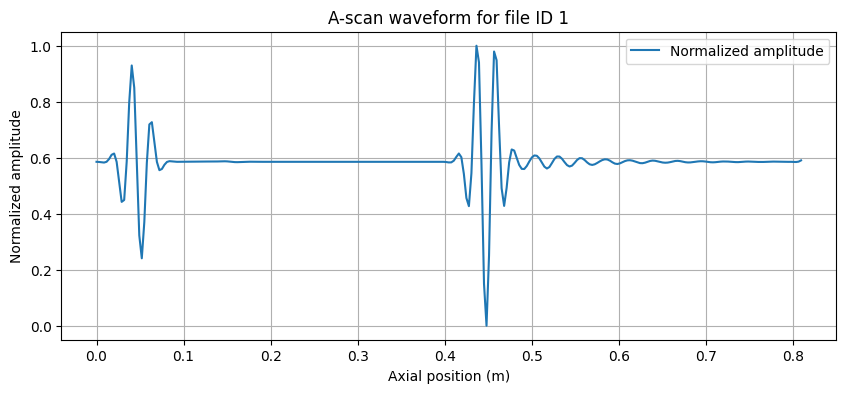

Detected 11 potential defect points at positions (m):
[0.037557 0.040446 0.043335 0.060669 0.063558 0.43335  0.436239 0.439128
 0.456462 0.459351 0.46224 ]
Report saved to pipe_report_file1.json


In [45]:
# -------------------------------
# A-scan Visualization & Defect Detection
# -------------------------------

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 1. Paths
# -------------------------------
data_folder = "/home/narges/Downloads/Simulated ultrasonic pulse-echo well-integrity dataset/Json Files"
metadata_file = "/home/narges/Downloads/Simulated ultrasonic pulse-echo well-integrity dataset/Metadata_overview.csv"

# -------------------------------
# 2. Load metadata
# -------------------------------
meta = pd.read_csv(metadata_file)
print("Metadata loaded. First 5 rows:")
print(meta.head())

# -------------------------------
# 3. Select a pipe model to analyze
# -------------------------------
file_id = 1  # example file ID

# Load JSON data
json_path = os.path.join(data_folder, f"{file_id}.json")
with open(json_path, "r") as f:
    data = json.load(f)

# -------------------------------
# 4. Extract metadata & waveform
# -------------------------------
height = data["general"]["height"]  # axial length (m)
vp_p = meta.loc[meta['file_ID'] == file_id, 'vp_p'].values[0]  # wave velocity inside pipe

waveform = np.array(data["waveform"]["values"])
# Normalize waveform 0-1 for plotting
waveform = (waveform - waveform.min()) / (waveform.max() - waveform.min())

t0 = data["waveform"]["t0"]
dt = data["waveform"]["dt"]
n_samples = data["waveform"]["sample_no"]

# Generate axial positions of samples
times = t0 + np.arange(n_samples) * dt
z = vp_p * times  # convert to meters along pipe axis

# -------------------------------
# 5. Plot A-scan
# -------------------------------
plt.figure(figsize=(10, 4))
plt.plot(z, waveform, label="Normalized amplitude")
plt.title(f"A-scan waveform for file ID {file_id}")
plt.xlabel("Axial position (m)")
plt.ylabel("Normalized amplitude")
plt.grid(True)
plt.legend()
plt.show()

# -------------------------------
# 6. Defect detection
# -------------------------------
threshold = 0.7  # example threshold
defect_indices = np.where(waveform > threshold)[0]
defect_positions = z[defect_indices]

print(f"Detected {len(defect_indices)} potential defect points at positions (m):")
print(defect_positions)

# -------------------------------
# 7. Save report
# -------------------------------
report = {
    "file_id": int(file_id),
    "height": float(height),
    "vp_p": float(vp_p) if isinstance(vp_p, np.generic) else vp_p,
    "defect_positions": defect_positions.tolist(),
    "num_defects": int(len(defect_positions)),
    "notes": "Detected potential defects based on amplitude threshold."
}

report_path = f"pipe_report_file{file_id}.json"
with open(report_path, "w") as f:
    json.dump(report, f, indent=4)

print(f"Report saved to {report_path}")

# -------------------------------
# 8. Note:
# For a full 3D visualization, loop over all files in the folder,
# map each waveform to an angular position around the pipe circumference,
# and construct a 3D point cloud as shown in previous scripts.
# -------------------------------


In [46]:
import numpy as np
from scipy.signal import find_peaks, welch

# Assume waveform is your amplitude array from JSON file

# 1) Find peaks above an amplitude threshold
threshold = 0.6 * max(np.abs(waveform))
peaks, _ = find_peaks(np.abs(waveform), height=threshold)

# 2) Calculate defect depths from ToF
vp_p = 5778  # example wave speed m/s from metadata
dt = 5e-7    # time step from JSON
times = np.arange(len(waveform)) * dt
depths = vp_p * times[peaks]

print("Potential defect depths (m):", depths)

# 3) Frequency spectrum analysis (power spectral density)
freqs, psd = welch(waveform, fs=1/dt, nperseg=256)

# Plot or analyze peaks in PSD to characterize defects further


Potential defect depths (m): [0.020223 0.040446 0.063558 0.416016 0.436239 0.456462 0.476685 0.502686
 0.528687]
